In [73]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle

# Save Results

## Load mlflow runs

In [75]:
db_port = 5001
db_name = 'cohirf'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
results_dir = Path.cwd().parent / "results" / "spheres-calinski"
os.makedirs(results_dir, exist_ok=True)

In [76]:
experiment_names

['Default',
 'sfni-SpectralSubspaceRandomization',
 'sfni-KMeans',
 'sfni-AffinityPropagation',
 'sfni-CompleteAgglomerativeClustering',
 'sfni-WardAgglomerativeClustering',
 'sfi-AffinityPropagation',
 'sfni-DBSCAN',
 'sfi-AverageAgglomerativeClustering',
 'sfni-CoHiRF',
 'sfi-Clique',
 'sfi-CoHiRF-DBSCAN',
 'sfni-CoHiRF-DBSCAN',
 'sfi-CoHiRF',
 'sfni-Clique',
 'sfi-CompleteAgglomerativeClustering',
 'sfi-DBSCAN',
 'sfni-AverageAgglomerativeClustering',
 'sfi-HDBSCAN',
 'sfni-HDBSCAN',
 'sfi-IRFLLRR',
 'sfni-IRFLLRR',
 'sfi-KMeans',
 'sfni-KMeansProj',
 'sfi-KMeansProj',
 'sfi-MeanShift',
 'sfni-OPTICS',
 'sfni-MeanShift',
 'sfi-OPTICS',
 'sfni-Proclus',
 'sfni-SingleAgglomerativeClustering',
 'sfni-SpectralClustering',
 'sfi-Proclus',
 'sfi-SingleAgglomerativeClustering',
 'sfi-SpectralClustering',
 'sfi-SpectralSubspaceRandomization',
 'sfi-WardAgglomerativeClustering',
 'sphere-AffinityPropagation',
 'sphere-AverageAgglomerativeClustering',
 'sphere-Clique',
 'sphere-CoHiRF-DBSCAN'

In [77]:
experiments_names = [exp for exp in experiment_names if exp.startswith("sphere-calinski")]

In [78]:
experiments_names

['sphere-calinski-AverageAgglomerativeClustering',
 'sphere-calinski-CompleteAgglomerativeClustering',
 'sphere-calinski-HDBSCAN',
 'sphere-calinski-IRFLLRR',
 'sphere-calinski-DBSCAN',
 'sphere-calinski-KMeans',
 'sphere-calinski-OPTICS',
 'sphere-calinski-Proclus',
 'sphere-calinski-SingleAgglomerativeClustering',
 'sphere-calinski-SpectralSubspaceRandomization',
 'sphere-calinski-WardAgglomerativeClustering',
 'sphere-calinski-CoHiRF',
 'sphere-calinski-CoHiRF-DBSCAN',
 'sphere-calinski-BatchCoHiRF-DBSCAN',
 'sphere-calinski-BatchCoHiRF-DBSCAN-1iter']

In [79]:
params_columns = [
    "model_nickname",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_spheres",
    "radius_separation",
    "radius_std",
    "add_radius_as_feature",
    "seed_unified",
]

In [80]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity',
    'completeness',
    'v_measure',
    'silhouette',
    'calinski_harabasz_score',
    'davies_bouldin_score',
    'inertia_score',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
    'best_calinski_harabasz_score',
    'best_davies_bouldin_score',
    'best_inertia_score',
    'best_homogeneity',
    'best_completeness',
    'best_v_measure',
]

In [81]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [82]:
# # parameters of each model, they are saved as tags for the parent run
# parameters = {
#     'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
#     'KMeans': ['n_clusters'],
#     'HDBSCAN': ['min_cluster_size'],
#     'DBSCAN': ['eps', 'min_samples'],
#     'AffinityPropagation': ['damping'],
#     'OPTICS': ['min_samples'],
#     'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
#     'WardAgglomerativeClustering': ['n_clusters'],
# }
# all_model_parameters = [p for model, params in parameters.items() for p in params]
# all_model_parameters = list(set(all_model_parameters))
# for param in all_model_parameters:
#     tags_columns.append(param)

In [83]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [84]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)
df_runs_raw.to_csv(results_dir / 'df_runs_raw.csv', index=True)

In [85]:
df_runs_raw = pd.read_csv(results_dir / "df_runs_raw.csv", index_col=0)
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [86]:
df_runs_raw_parents

,status,start_time,end_time,add_radius_as_feature,model_nickname,n_samples,n_spheres,radius_separation,radius_std,seed_dataset,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
008135c21e2a48bd938376ef1405bfea,FINISHED,1750094625452,1.750095e+12,False,Proclus,20000,2,0.5,0.01,0,...,0.193760,8.0,0.143435,0.554617,-0.048424,0.143435,NaN,05146e70658644cfbd626761bce2cb16,NaN,False
0100a32882194f69a0ffb020bd72fb10,FINISHED,1750094318757,1.750094e+12,False,CompleteAgglomerativeClustering,2000,2,0.5,0.01,0,...,0.426908,25.0,0.235413,0.549674,0.175162,0.235413,NaN,4f0a670318424356975eec945a7760d2,NaN,False
010b7c76c1f1493f8085389e3350ff8b,FINISHED,1750094594272,1.750095e+12,False,SingleAgglomerativeClustering,2000,2,0.5,0.01,0,...,0.693147,24.0,0.810596,0.947399,-0.310250,0.810596,NaN,335b1e2d2abd4bf9a9681473b023c9bc,NaN,False
0450c8adcc2842f38b861f0d2b3950f3,RUNNING,1750094537439,NaN,False,IRFLLRR,20000,2,0.5,0.01,0,...,0.000733,29.0,0.000431,0.500009,0.005495,0.000431,NaN,NaN,NaN,NaN
04d22fc29bc14ad9aebf0d224dabd2bc,FINISHED,1750094593958,1.750095e+12,False,SingleAgglomerativeClustering,20000,2,0.5,0.01,0,...,0.693147,15.0,0.989724,0.998403,0.017804,0.989724,NaN,56a7ec83787b4ec9b9380f6e2270370d,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fb14b4b1724d45f6bdc8f921dc4460c3,FINISHED,1750095088332,1.750095e+12,False,CoHiRF-DBSCAN,2000,2,0.5,0.01,0,...,0.000000,1.0,0.000000,0.499750,-1.000000,0.000000,NaN,075873e2f53b4711ad955b56745b9203,NaN,False
fb717ecef19f4bbf971a88049a73b894,FINISHED,1750094668665,1.750095e+12,False,SpectralSubspaceRandomization,200,2,0.5,0.01,0,...,0.490541,18.0,0.279920,0.546935,-0.025729,0.279920,NaN,3db74caae52e44a98e208db388dc8b9d,NaN,False
fd4ffaa91c844290a85f506ff87a1683,FINISHED,1750094745420,1.750095e+12,False,CoHiRF,20000,2,0.5,0.01,0,...,0.000065,4.0,0.000074,0.499996,0.014430,0.000074,NaN,ff05edc8e9d84366880436970bbc9278,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [87]:
non_duplicate_columns = [
    "model_nickname",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_spheres",
    "radius_separation",
    "radius_std",
    "add_radius_as_feature",
    "seed_unified",
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how="all", subset=["best_adjusted_rand"]).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]
# fill missing values with "None"
df_runs_parents = df_runs_parents.fillna("None")

/tmp/ipykernel_247616/3019381152.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_runs_parents = df_runs_parents.fillna("None")


# Missing

In [88]:
model_nickname = df_runs_parents['model_nickname'].unique().tolist()
model_nickname.sort()
model_nickname

['AverageAgglomerativeClustering',
 'CoHiRF',
 'CoHiRF-DBSCAN',
 'CompleteAgglomerativeClustering',
 'DBSCAN',
 'HDBSCAN',
 'IRFLLRR',
 'KMeans',
 'OPTICS',
 'Proclus',
 'SingleAgglomerativeClustering',
 'SpectralSubspaceRandomization',
 'WardAgglomerativeClustering']

In [89]:
model_nickname = [
    "AverageAgglomerativeClustering",
    "CoHiRF",
    "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering",
    "DBSCAN",
    "HDBSCAN",
    "IRFLLRR",
    "KMeans",
    "OPTICS",
    "Proclus",
    "SingleAgglomerativeClustering",
    "SpectralSubspaceRandomization",
    "WardAgglomerativeClustering",
]

In [90]:
non_duplicate_columns = [
    "model_nickname",
    # "seed_model",
    # "seed_dataset",
    "n_samples",
    # "n_spheres",
    # "radius_separation",
    # "radius_std",
    # "add_radius_as_feature",
    "seed_unified",
]

In [91]:
n_samples = [200, 2000, 20000]#, 200000]
seed_unified = [i for i in range(4)]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, seed_unified]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)
df_missing = df_missing.rename(columns={"seed_unified": "seeds_unified"})

In [92]:
df_missing

,model_nickname,n_samples,seeds_unified
0,IRFLLRR,20000,0
1,IRFLLRR,20000,1
2,IRFLLRR,20000,2
3,IRFLLRR,20000,3
4,SpectralSubspaceRandomization,20000,0
5,SpectralSubspaceRandomization,20000,1
6,SpectralSubspaceRandomization,20000,2
7,SpectralSubspaceRandomization,20000,3


In [53]:
# Join df_runs_raw_parents into df_missing using non_duplicate_columns to get the EXCEPTION column
df_missing_with_exception = df_missing.merge(
    df_runs_raw_parents[non_duplicate_columns + ["EXCEPTION"]],
    how="left",
    left_on=["model_nickname", "n_samples", "seeds_unified"],
    right_on=["model_nickname", "n_samples", "seed_unified"],
)
df_missing_with_exception[["model_nickname", "n_samples", "seeds_unified", "EXCEPTION"]]

,model_nickname,n_samples,seeds_unified,EXCEPTION
0,IRFLLRR,20000,0,NaN
1,IRFLLRR,20000,0,NaN
2,IRFLLRR,20000,0,NaN
3,IRFLLRR,20000,1,NaN
4,IRFLLRR,20000,1,NaN
5,IRFLLRR,20000,1,NaN
6,IRFLLRR,20000,2,NaN
7,IRFLLRR,20000,2,NaN
8,IRFLLRR,20000,3,NaN
9,IRFLLRR,20000,3,NaN


In [54]:
df_missing.model_nickname.unique()

array(['IRFLLRR', 'SpectralSubspaceRandomization'], dtype=object)

In [30]:
missing_dict = {}
for model in df_missing['model_nickname'].unique():
	sub = df_missing[df_missing['model_nickname'] == model].drop(columns=['model_nickname'])
	missing_dict[model] = sub.to_dict(orient='records')
if len(missing_dict) != 0:
    with open(results_dir / 'missing_dict.pkl', 'wb') as f:
        pickle.dump(missing_dict, f)

# Get common combinations

In [55]:
model_nickname = [
    "AverageAgglomerativeClustering",
    "CoHiRF",
    "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering",
    "DBSCAN",
    "HDBSCAN",
    # "IRFLLRR",
    "KMeans",
    "OPTICS",
    "Proclus",
    "SingleAgglomerativeClustering",
    # "SpectralSubspaceRandomization",
    "WardAgglomerativeClustering",
]
df = df_runs_parents.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = [
    "n_samples",
    "seed_unified",
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [56]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [57]:
df_common['n_samples'] = df_common['n_samples'].astype(int)

In [58]:
# Join df_common with df_runs_raw to get the time of best_child_run_id
df_common["best_child_time"] = df_common["best_child_run_id"].map(df_runs_raw["fit_model_return_elapsed_time"])

In [59]:
df_common

,status,start_time,end_time,add_radius_as_feature,model_nickname,n_samples,n_spheres,radius_separation,radius_std,seed_dataset,...,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception,best_child_time
run_uuid,,,,,,,,,,,,,,,,,,,,,
008135c21e2a48bd938376ef1405bfea,FINISHED,1750094625452,1.750095e+12,False,Proclus,20000,2,0.5,0.01,0,...,8.0,0.143435,0.554617,-0.048424,0.143435,None,05146e70658644cfbd626761bce2cb16,None,False,5.968735
0100a32882194f69a0ffb020bd72fb10,FINISHED,1750094318757,1.750094e+12,False,CompleteAgglomerativeClustering,2000,2,0.5,0.01,0,...,25.0,0.235413,0.549674,0.175162,0.235413,None,4f0a670318424356975eec945a7760d2,None,False,0.088501
010b7c76c1f1493f8085389e3350ff8b,FINISHED,1750094594272,1.750095e+12,False,SingleAgglomerativeClustering,2000,2,0.5,0.01,0,...,24.0,0.810596,0.947399,-0.310250,0.810596,None,335b1e2d2abd4bf9a9681473b023c9bc,None,False,0.031846
04d22fc29bc14ad9aebf0d224dabd2bc,FINISHED,1750094593958,1.750095e+12,False,SingleAgglomerativeClustering,20000,2,0.5,0.01,0,...,15.0,0.989724,0.998403,0.017804,0.989724,None,56a7ec83787b4ec9b9380f6e2270370d,None,False,2.878657
07915a29e76449d6bff1bb85666fbabb,FINISHED,1750094406604,1.750095e+12,False,CompleteAgglomerativeClustering,20000,2,0.5,0.01,0,...,14.0,0.427928,0.704672,0.109074,0.427928,None,2e403c89257647d384e3bba56db0e99a,None,False,10.668416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f86909f4caa84117974d2de0deca6010,FINISHED,1750094419611,1.750095e+12,False,HDBSCAN,20000,2,0.5,0.01,0,...,2.0,1.000000,1.000000,0.093334,1.000000,None,a764254e27944c74a2531b78b4a5cba8,None,False,3.852421
fb14b4b1724d45f6bdc8f921dc4460c3,FINISHED,1750095088332,1.750095e+12,False,CoHiRF-DBSCAN,2000,2,0.5,0.01,0,...,1.0,0.000000,0.499750,-1.000000,0.000000,None,075873e2f53b4711ad955b56745b9203,None,False,0.149243
fd4ffaa91c844290a85f506ff87a1683,FINISHED,1750094745420,1.750095e+12,False,CoHiRF,20000,2,0.5,0.01,0,...,4.0,0.000074,0.499996,0.014430,0.000074,None,ff05edc8e9d84366880436970bbc9278,None,False,0.601242


# Plots

/tmp/ipykernel_247616/3238643165.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


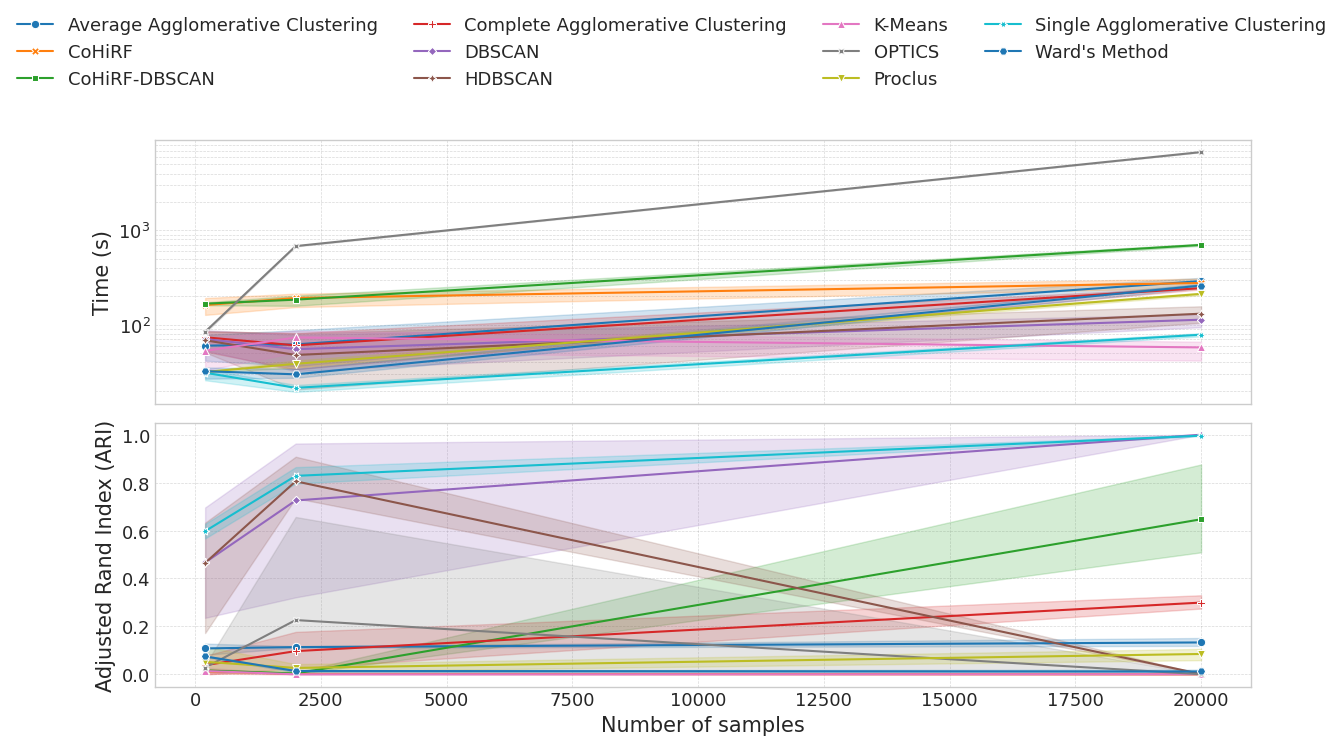

In [69]:
import matplotlib.ticker as mticker

df = df_common.copy()
models_names = {
	"AffinityPropagation": "Affinity Propagation",
	"AverageAgglomerativeClustering": "Average Agglomerative Clustering",
	"CoHiRF": "CoHiRF",
	"CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
	"CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
	"DBSCAN": "DBSCAN",
	"HDBSCAN": "HDBSCAN",
	"IRFLLRR": "IRFLLRR",
	"KMeans": "K-Means",
	"MeanShift": "Mean Shift",
	"OPTICS": "OPTICS",
	"Proclus": "Proclus",
	"SingleAgglomerativeClustering": "Single Agglomerative Clustering",
	"SpectralClustering": "Spectral Clustering",
	"SpectralSubspaceRandomization": "SC-SRGF",
	"WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
	columns={
		"fit_model_return_elapsed_time": "Time (s)",
		"max_memory_used": "Memory (MB)",
		"n_samples": "Number of samples",
		"model_nickname": "Model",
		"best_adjusted_rand": "ARI",
	}
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
	rc={
		"figure.constrained_layout.use": True,
		"savefig.bbox": "tight",
		"figure.figsize": (12, 7),
		"legend.loc": "upper left",
		"legend.frameon": True,
		"font.size": 14,
		"axes.titlesize": 16,
		"axes.labelsize": 15,
		"xtick.labelsize": 13,
		"ytick.labelsize": 13,
		"axes.grid": True,
		"grid.color": "grey",
		"grid.alpha": 0.3,
	}
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
		data=df,
		x="Number of samples",
		y="Time (s)",
		hue="Model",
		style="Model",
		markers=True,
		dashes=False,
		errorbar="ci",
		ax=axs[0],
		palette=palette,
	)
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
		data=df,
		x="Number of samples",
		y="ARI",
		hue="Model",
		style="Model",
		markers=True,
		dashes=False,
		errorbar="ci",
		ax=axs[1],
		palette=palette,
	)
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of samples")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.savefig(results_dir / f"hpo_sphere_calinski_all.pdf", dpi=300)
    plt.show()

/tmp/ipykernel_247616/1319673168.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


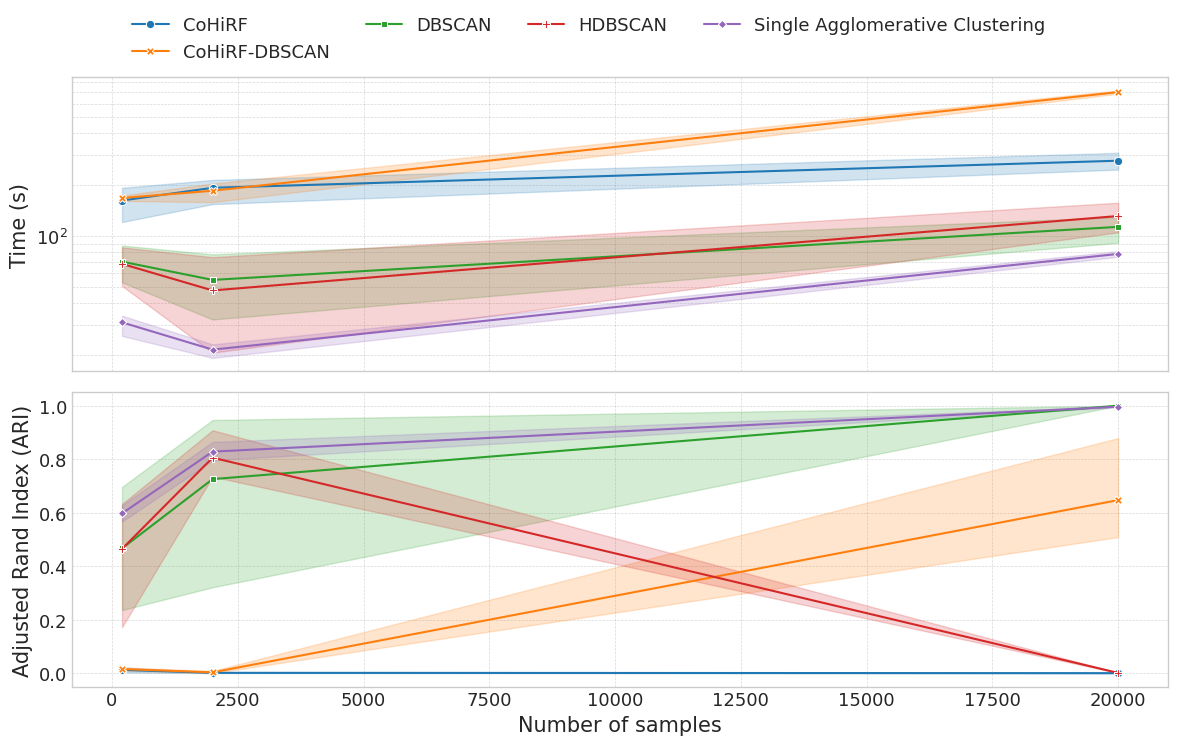

In [70]:
import matplotlib.ticker as mticker

df = df_common.copy()
models_names = {
    # "AffinityPropagation": "Affinity Propagation",
    # "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    # "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    "DBSCAN": "DBSCAN",
    "HDBSCAN": "HDBSCAN",
    # "IRFLLRR": "IRFLLRR",
    # "KMeans": "K-Means",
    # "MeanShift": "Mean Shift",
    # "OPTICS": "OPTICS",
    # "Proclus": "Proclus",
    "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    # "SpectralClustering": "Spectral Clustering",
    # "SpectralSubspaceRandomization": "SC-SRGF",
    # "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "fit_model_return_elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of samples",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of samples",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of samples")
    plt.tight_layout()
    # plt.subplots_adjust(top=0.88)
    plt.savefig(results_dir / f"hpo_sphere_calinski.pdf", dpi=300)
    plt.show()

/tmp/ipykernel_247616/708260971.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


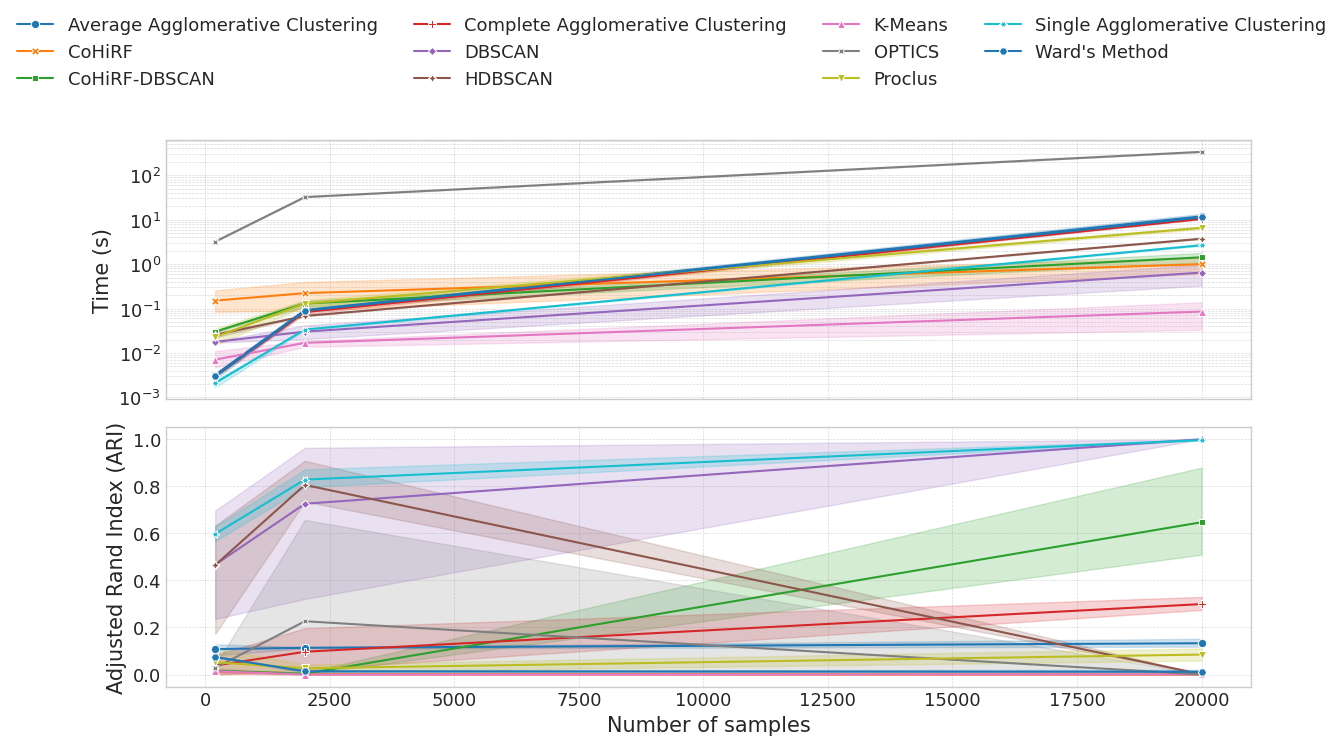

In [71]:
import matplotlib.ticker as mticker

df = df_common.copy()
models_names = {
    "AffinityPropagation": "Affinity Propagation",
    "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    "DBSCAN": "DBSCAN",
    "HDBSCAN": "HDBSCAN",
    "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    "MeanShift": "Mean Shift",
    "OPTICS": "OPTICS",
    "Proclus": "Proclus",
    "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "best_child_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of samples",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of samples",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of samples")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    plt.savefig(results_dir / f"best_sphere_calinski_all.pdf", dpi=300)
    plt.show()

/tmp/ipykernel_247616/3727491764.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


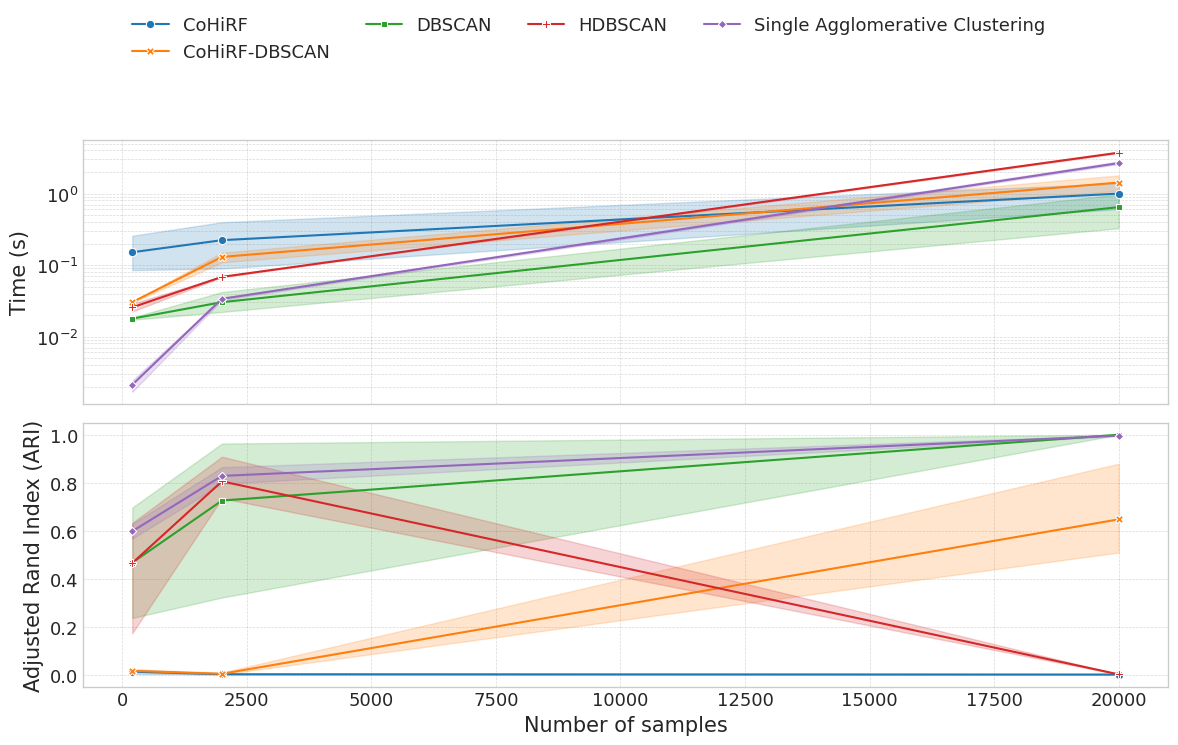

In [72]:
import matplotlib.ticker as mticker

df = df_common.copy()
models_names = {
    # "AffinityPropagation": "Affinity Propagation",
    # "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    # "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    "DBSCAN": "DBSCAN",
    "HDBSCAN": "HDBSCAN",
    # "IRFLLRR": "IRFLLRR",
    # "KMeans": "K-Means",
    # "MeanShift": "Mean Shift",
    # "OPTICS": "OPTICS",
    # "Proclus": "Proclus",
    "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    # "SpectralClustering": "Spectral Clustering",
    # "SpectralSubspaceRandomization": "SC-SRGF",
    # "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "best_child_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of samples",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of samples",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of samples")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    plt.savefig(results_dir / f"best_sphere_calinski.pdf", dpi=300)
    plt.show()

# Debug and explore

In [21]:
df = df_runs_raw.copy()
df = df.loc[df['model_nickname'].isin(['IRFLLRR', 'Proclus', 'SpectralSubspaceRandomization'])]

In [22]:
runs_to_delete = list(df.index)

In [23]:
print(runs_to_delete, len(runs_to_delete))

['001173a81d124facb9aa562b72401c21', '0086a789cf1b4a38bd8f0871eb281f4d', '00902b9d1fb64bef8578c1b72b03a670', '0093bb3791274853834c8df1e3a91c2b', '00d66d981f6941279311c8301b83d5b5', '00d6be43b68e4a8bbf4b02d89ecf4a64', '00e4b3b99cf148c18ead312f7480bba5', '00e513858c264142ac10eb49e7a8a867', '00e7f373687a42c4af5dec1a86d22b17', '0148496edcf54743b8e80cc284713220', '01526b65140b408ab2eca50800a70d97', '01a48af95a1449d6ad8104966901074b', '01dce32d4ae54a43bb0954b2a94e61ce', '022d97a89c784db0a736a202620e28d0', '025799c45d8b41e6b3764d86f4d7255f', '0260c98e749b45589d8412e831c00602', '02854240905e47e4a58d29148e0af556', '02a31727c15f4635aec889cbaa152251', '02cba259c9724b1a849748c261da38a6', '0323245a2b1845768255aa38866ac0f3', '034f3c015d77460cbd23c1e353e83be9', '035b7bee71fd4eedad951f18b88542ce', '036be490942d4140a6322632528e7085', '0373c815f4b146d4893709984695f907', '037eccf1f6994b3b8b7383133b6b05a9', '03b3e483f157449ca20a3e129d9d0f37', '03e151bbe72f4b31a3e2c36cecea4ba5', '03fc6446f5e5473e8105e36fd6

In [24]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [25]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

In [26]:
query = f"""
DELETE
FROM
	experiment_tags
WHERE
	experiment_id = ANY(
	SELECT
		experiment_id
	FROM
		experiments
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	latest_metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	params
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	tags
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE 
FROM 
	runs
WHERE 
	lifecycle_stage = 'deleted';

DELETE 
FROM 
	experiments
WHERE 
	lifecycle_stage = 'deleted';
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    